In [44]:
import pandas as pd
import re
from string import punctuation
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA

import pickle

import os
import gensim

from pprint import pprint
import seaborn as sns
import matplotlib.colors as mcolors
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from collections import Counter
import matplotlib.colors as mcolors

import pickle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt 
import pandas as pd
import spacy
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel

In [2]:
news = pd.read_csv('200.csv')

In [3]:

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


In [4]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      6 non-null      int64 
 1   uid             6 non-null      object
 2   article_author  6 non-null      object
 3   article_date    4 non-null      object
 4   article_text    6 non-null      object
 5   article_url     6 non-null      object
dtypes: int64(1), object(5)
memory usage: 416.0+ bytes


In [6]:
news = news.drop(columns=['Unnamed: 0','uid','article_author','article_date','article_url'], axis=1)



In [7]:
news.head()

,article_text
0,The Ukrainian army destroyed an enemy column i...
1,"In Chernihiv region, Ukrainian defenders burne..."
2,Soldiers of the 93rd separate mechanised briga...
3,"Thursday, 3 March 2022, 05:00\n\nUkraine’s Arm..."
4,There is also evidence that two military units...


In [8]:
news['article_text']

0    The Ukrainian army destroyed an enemy column i...
1    In Chernihiv region, Ukrainian defenders burne...
2    Soldiers of the 93rd separate mechanised briga...
3    Thursday, 3 March 2022, 05:00\n\nUkraine’s Arm...
4    There is also evidence that two military units...
5    4 Mar 2022 00.27 Summary It is 7.27am in Ukrai...
Name: article_text, dtype: object

# Tokenize Sentences and Clean

In [9]:
def sent_to_words(sentences):
    for sent in sentences:
        
        sent = re.sub('[,\.!?]', '', sent)  # remove emails
        sent = sent.lower()  
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  


In [13]:
data = news['article_text'].values.tolist()

data_words = list(sent_to_words(data))

data_words

[['the',
  'ukrainian',
  'army',
  'destroyed',
  'an',
  'enemy',
  'column',
  'in',
  'the',
  'north',
  'of',
  'the',
  'poltava',
  'region',
  'last',
  'night',
  'the',
  'losses',
  'of',
  'the',
  'invaders',
  'are',
  'being',
  'clarified',
  'the',
  'head',
  'of',
  'the',
  'poltava',
  'regional',
  'military',
  'administration',
  'dmytro',
  'lunin',
  'reported',
  'this',
  'on',
  'facebook',
  'ukrinform',
  'reports',
  'the',
  'eighth',
  'day',
  'of',
  'the',
  'heroic',
  'struggle',
  'the',
  'situation',
  'in',
  'the',
  'poltava',
  'region',
  'is',
  'under',
  'control',
  'this',
  'night',
  'the',
  'ukrainian',
  'army',
  'destroyed',
  'column',
  'of',
  'russian',
  'hardware',
  'in',
  'the',
  'north',
  'of',
  'the',
  'region',
  'the',
  'enemys',
  'losses',
  'are',
  'being',
  'clarified',
  'lunin',
  'said',
  'lunin',
  'published',
  'videos',
  'and',
  'photos',
  'of',
  'the',
  'broken',
  'equipment',
  'on',
  '

# Build the Bigram, Trigram Models and Lemmatize

lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=2, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [21]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data) 


In [22]:
data_ready

[['ukrainian',
  'destroy',
  'enemy',
  'column',
  'region',
  'last',
  'night',
  'loss',
  'invader',
  'clarify',
  'head',
  'military',
  'administration',
  'dmytro',
  'lunin',
  'report',
  'facebook',
  'ukrinform',
  'report',
  'eighth',
  'day',
  'heroic',
  'struggle',
  'situation',
  'control',
  'night',
  'destroy',
  'column',
  'russian',
  'hardware',
  'north',
  'region',
  'enemy',
  'loss',
  'clarify',
  'lunin',
  'lunin',
  'publish',
  'video',
  'photo',
  'broken',
  'equipment',
  'telegram',
  'channel',
  'invader',
  'understand',
  'thing',
  'sword',
  'die',
  'excellent',
  'work',
  'region',
  'border',
  'sumy',
  'poltava',
  'region',
  'write',
  'note',
  'region',
  'work',
  'underway',
  'strengthen',
  'defense',
  'region',
  'ten',
  'tonne',
  'aid',
  'send',
  'kharkiv',
  'region',
  'food',
  'form',
  'announce',
  'begin',
  'invasion',
  'ukraine',
  'russian',
  'troop',
  'shell',
  'destroy',
  'key',
  'infrastructure',

# Build the Topic Model
we can set the num of topic to choose how many topic we want 

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.035*"military" + 0.031*"russian" + 0.021*"destroy" + 0.018*"region" + '
  '0.018*"ukraine" + 0.018*"force" + 0.018*"trostyanet" + 0.014*"troop" + '
  '0.014*"unit" + 0.014*"accord"'),
 (1,
  '0.039*"plant" + 0.032*"nuclear" + 0.022*"power" + 0.021*"emergency" + '
  '0.019*"russian" + 0.016*"ukraine" + 0.014*"fire" + 0.013*"force" + '
  '0.013*"building" + 0.011*"local"'),
 (2,
  '0.034*"region" + 0.023*"ukraine" + 0.023*"russian" + 0.019*"destroy" + '
  '0.019*"column" + 0.019*"ukrainian" + 0.016*"report" + 0.012*"enemy" + '
  '0.012*"lunin" + 0.012*"announce"'),
 (3,
  '0.004*"plant" + 0.003*"russian" + 0.003*"emergency" + 0.003*"nuclear" + '
  '0.003*"fire" + 0.003*"power" + 0.003*"ukraine" + 0.003*"situation" + '
  '0.003*"local" + 0.003*"training"')]


# Attention
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [25]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9918,"region, ukraine, russian, destroy, column, ukr...","[ukrainian, destroy, enemy, column, region, la..."
1,1,2.0,0.9913,"region, ukraine, russian, destroy, column, ukr...","[region, ukrainian, defender, burn, whole, col..."
2,2,0.0,0.9777,"military, russian, destroy, region, ukraine, f...","[soldier, rd, separate, mechanised, brigade, f..."
3,3,0.0,0.9907,"military, russian, destroy, region, ukraine, f...","[armed, force, destroy, enemy, equipment, stop..."
4,4,0.0,0.9916,"military, russian, destroy, region, ukraine, f...","[evidence, military, unit, almost, completely,..."
5,5,1.0,0.9986,"plant, nuclear, power, emergency, russian, ukr...","[summary, ukraine, war, neighbour, enter, nint..."


# get samples of sentences that most represent a given topic.

In [26]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9916,"military, russian, destroy, region, ukraine, force, trostyanet, troop, unit, accord","[evidence, military, unit, almost, completely, destroy, ukraine, ukrainian, destroy, convoy, ene..."
1,1.0,0.9986,"plant, nuclear, power, emergency, russian, ukraine, fire, force, building, local","[summary, ukraine, war, neighbour, enter, ninth, day, crisis, stand, fire, break, training, buil..."
2,2.0,0.9918,"region, ukraine, russian, destroy, column, ukrainian, report, enemy, lunin, announce","[ukrainian, destroy, enemy, column, region, last, night, loss, invader, clarify, head, military,..."


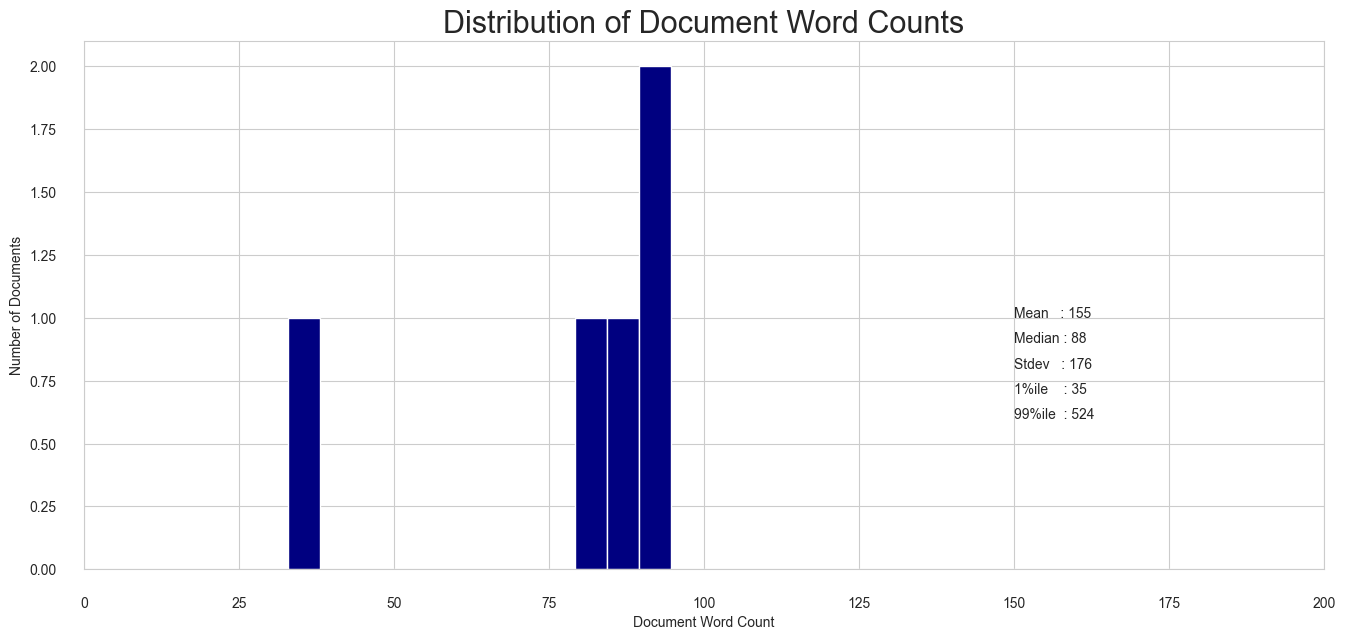

In [38]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=100)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(150, 1, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(150,  0.9, "Median : " + str(round(np.median(doc_lens))))
plt.text(150,  0.8, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(150,  0.7, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(150,  0.6, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 200), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,200,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


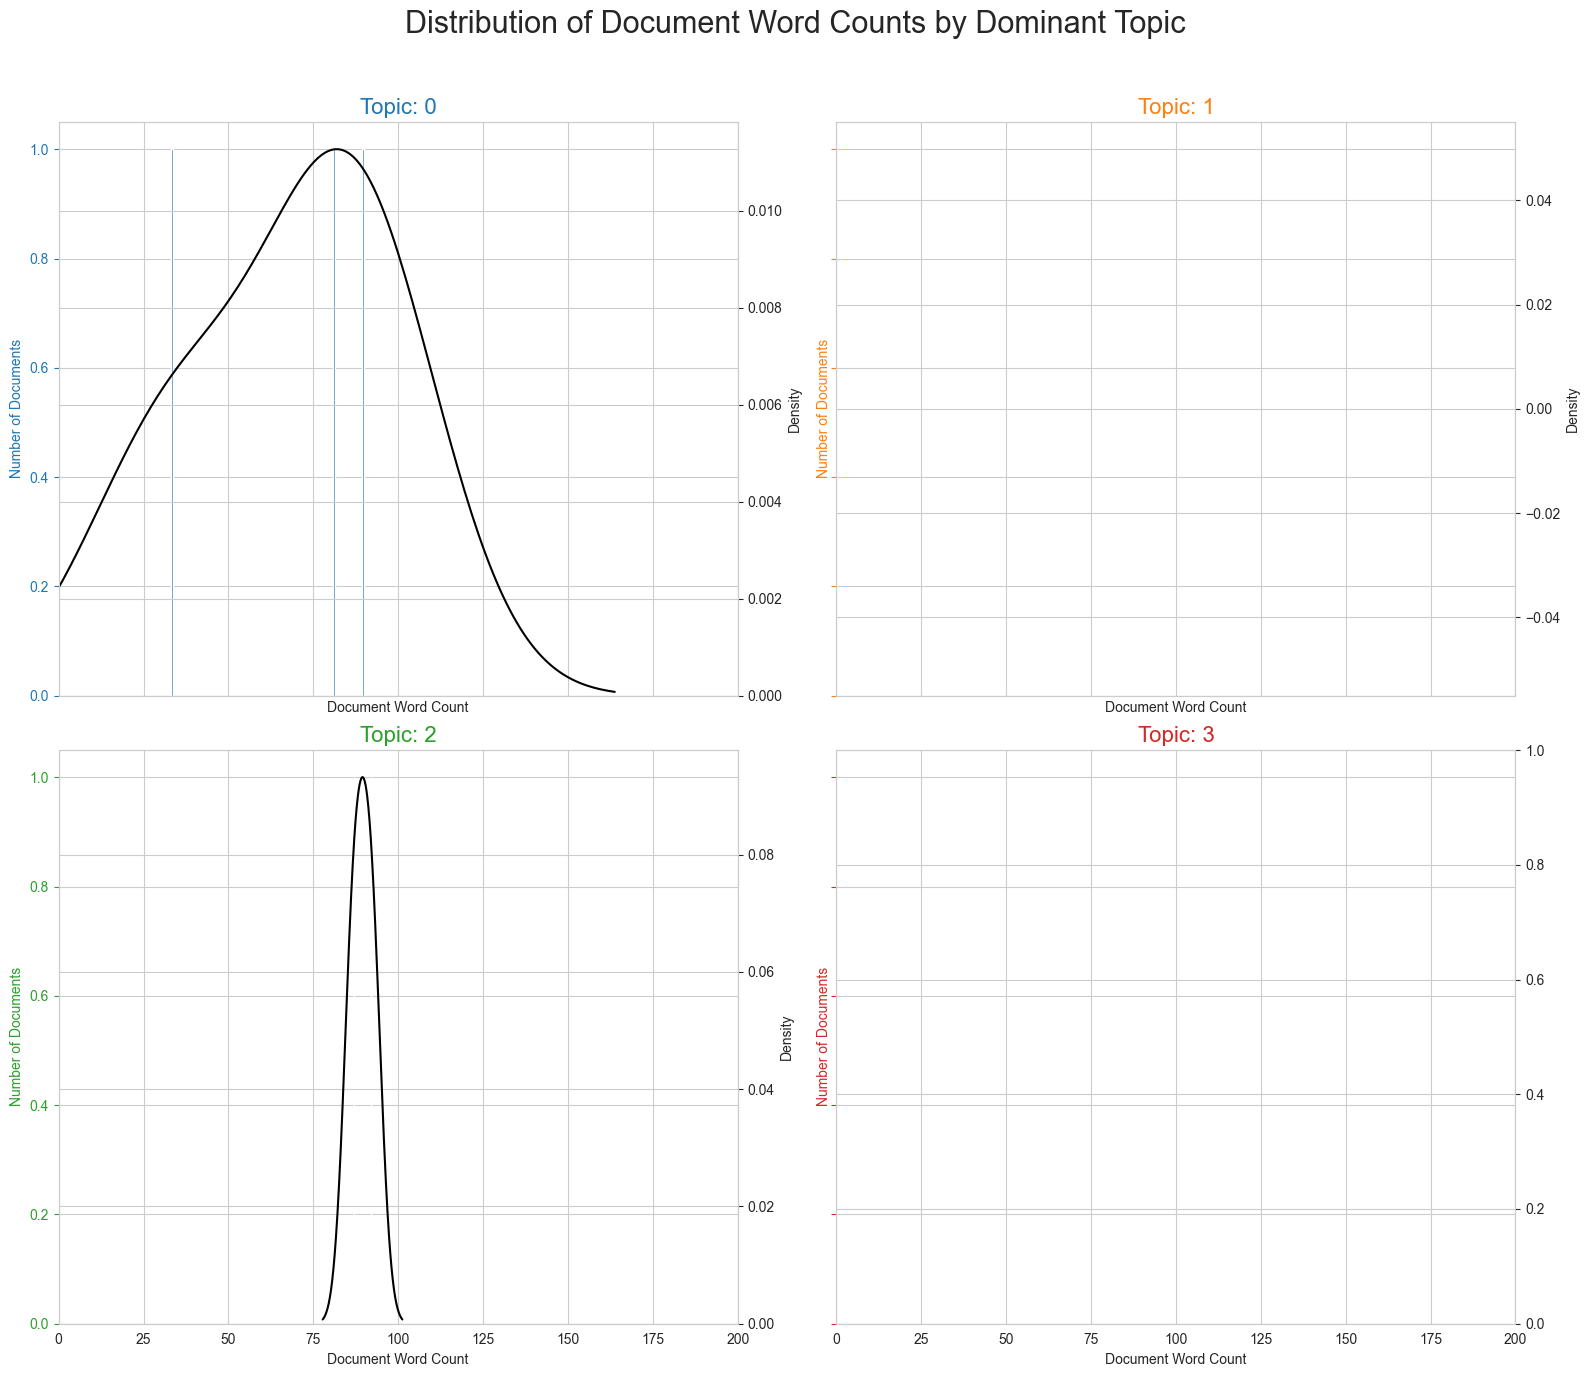

In [41]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=100, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 200), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,200,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()


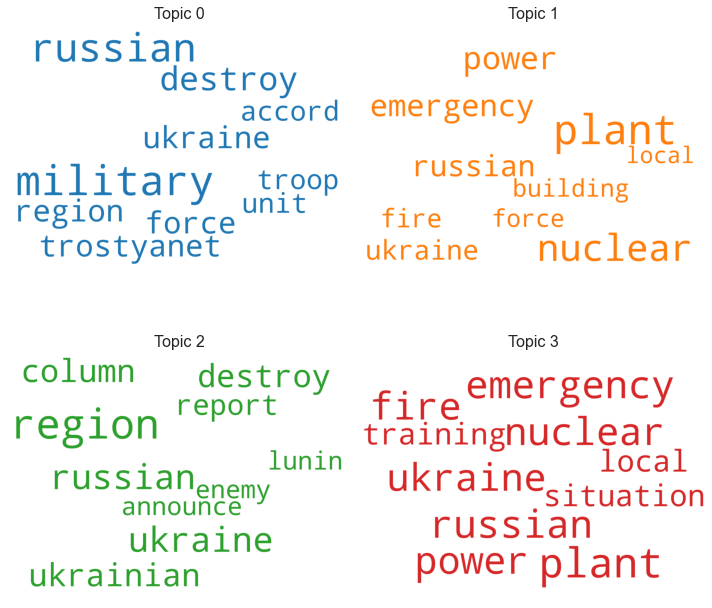

In [43]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [145]:
temp = []
while n < len(news['article_text']):
    news['news_text_processed'] = str(news['title'][n])
    n = n+1
    temp.append(news['news_text_processed'])
temp

[]

In [165]:
news['title'] = str(news['title'])

In [168]:

# Remove punctuation
news['news_text_processed'] = news['title'].map(lambda x: re.sub(r'[{}]+'.format(punctuation),' ',x)



SyntaxError: unexpected EOF while parsing (305120170.py, line 3)

In [169]:

# Join the different processed titles together.
long_string = ','.join(list(news['news_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

KeyError: 'news_text_processed'

In [170]:

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


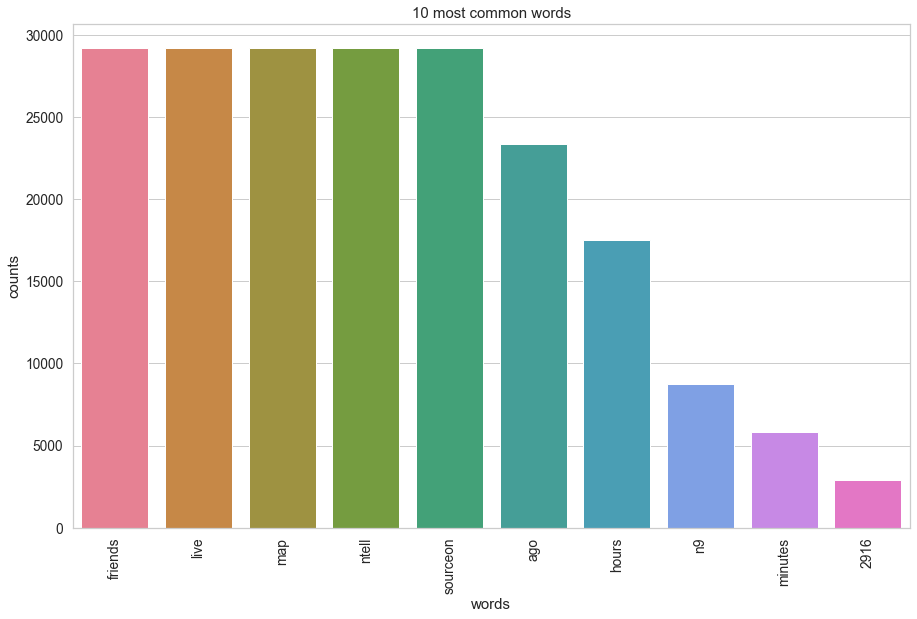

In [55]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(news['news_text_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [61]:
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 2000
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda_model = lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #2:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #3:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #4:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #5:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #6:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #7:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #8:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #9:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #10:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #11:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #12:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #13:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #14:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #15:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #16:
text live 2917 2

/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1207:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1208:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1209:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1210:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1211:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1212:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1213:
live map ntell friends sourceon ago hours n9 minutes hour

Topic #1214:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1215:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1216:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1217:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1218:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1219:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1220:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #1221:
text live 2917 2918 2919 2920 2921 ag ago dtype

Topic #122

In [57]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis
import os

LDAvis_data_filepath = os.path.join('./ldavis_prepared_' + str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
with open(LDAvis_data_filepath, 'w') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_' + str(number_topics) + '.html')

# 在win10上运行要很久，先中断了，有时间再跑下



/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


KeyboardInterrupt: 

/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/op

In [68]:

vis = pyLDAvis.gensim_models.prepare(lda_model, news['news_text_processed'], 'text')
vis

ValueError: not enough values to unpack (expected 2, got 1)